In [47]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.feature_selection import SelectFromModel,SequentialFeatureSelector

from sklearn.metrics import f1_score,accuracy_score,recall_score,precision_score,confusion_matrix,roc_auc_score

import warnings
warnings.simplefilter('ignore')

In [12]:
def model_basic(x_train, y_train, x_test, y_test):
    models = [
        LogisticRegression(),
        LinearDiscriminantAnalysis(),
        GaussianNB(),
        RandomForestClassifier(),
        XGBClassifier(),
        
    ]

    rdict = {'model': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1_score': [], 'auc_score': []}

    for clf in models:
        clf = clf.fit(x_train, y_train)
        pred = clf.predict(x_test)
        pred_prob_rf = clf.predict_proba(x_test)[:, 1].reshape(-1, 1)
        auc_score = roc_auc_score(y_test, pred_prob_rf)
        results = (
            round(accuracy_score(y_test, pred), 4),
            round(precision_score(y_test, pred), 4),
            round(recall_score(y_test, pred), 4),
            round(f1_score(y_test, pred), 4),
            round(auc_score, 4)
        )

        rdict['model'].append(clf)
        rdict['accuracy'].append(results[0])
        rdict['precision'].append(results[1])
        rdict['recall'].append(results[2])
        rdict['f1_score'].append(results[3])
        rdict['auc_score'].append(results[4])

        confusion = confusion_matrix(y_test, pred)
        print(confusion)

    rdf = pd.DataFrame(data=rdict)
    return rdf

In [13]:
train = pd.read_csv('./datasets/통계검증완료/코스피_power_train.csv',index_col=0)
test =  pd.read_csv('./datasets/통계검증완료/코스피_power_test.csv',index_col=0)

In [14]:
# train = pd.read_csv('./datasets/통계검증완료/코스피_robu_train.csv',index_col=0)
# test =  pd.read_csv('./datasets/통계검증완료/코스피_robu_test.csv',index_col=0)
# np.random.RandomState(1)

---
# 산업별 더미변수 - 제조업,건설업,정보통신업,그외
---

In [15]:
# train.loc[~(train['산업군'].str.contains('제조업') | train['산업군'].str.contains('건설업') | train['산업군'].str.contains('정보통신업')), '산업군'] = '그 외'
# dummy_df = pd.get_dummies(train['산업군'])
# train = pd.concat([train,dummy_df],axis=1)

In [16]:
# test.loc[~(test['산업군'].str.contains('제조업') | test['산업군'].str.contains('건설업') | test['산업군'].str.contains('정보통신업')), '산업군'] = '그 외'
# dummy_df = pd.get_dummies(test['산업군'])
# test = pd.concat([test,dummy_df],axis=1)

----

In [17]:
train.columns

Index(['회사명', '거래소코드', '회계년도', '산업군', 'target_1', 'target_2', 'target_3',
       '현금흐름 대 자산', '현금흐름 대 매출액', '현금흐름/총부채비율', '총자본정상영업이익률', 'EBIT/총자산',
       '타인자본회전률', '이익잉여금', '당기전기영업손익', '누적수익성비율', 'EBITDA마진율', '순운전자본비율',
       '자기자본순이익률', '금융비용부담률', '자기자본회전률', '자본금회전률', '시총/총자산', '외국인지분율',
       'abs(영업현금흐름-당기순이익)/매출액', '총자본증가율', '매출액총이익률', '매출액증가율', '대주주지분율',
       '자기자본증가율', 'ROA변화율', '정상영업이익증가율'],
      dtype='object')

In [18]:
col_int = ['현금흐름 대 자산', '현금흐름 대 매출액', '현금흐름/총부채비율', '총자본정상영업이익률', 'EBIT/총자산',
       '타인자본회전률', '이익잉여금', '당기전기영업손익', '누적수익성비율', 'EBITDA마진율', '순운전자본비율',
       '자기자본순이익률', '금융비용부담률', '자기자본회전률', '자본금회전률', '시총/총자산', '외국인지분율',
       'abs(영업현금흐름-당기순이익)/매출액', '총자본증가율', '매출액총이익률', '매출액증가율', '대주주지분율',
       '자기자본증가율', 'ROA변화율', '정상영업이익증가율']

---
#target1
---

In [44]:
x_train = train[col_int]
y_train = train[['target_1']]

x_test = test[col_int]
y_test = test[['target_1']]

In [20]:
#  선정된 피쳐를 저장하기 위한 데이터프레임 생성 
df_select = pd.DataFrame()
# 생성된 데이터프레임의 인덱스 지정
df_select.index = x_train.columns

---
# lasso - 임베디드기법
---

In [21]:
#  lasso
selector = SelectFromModel(estimator=LogisticRegression(penalty='l1',solver='liblinear',C=0.01)).fit(x_train, y_train)
df_select["lasso_0.01"] = selector.get_support()

selector = SelectFromModel(estimator=LogisticRegression(penalty='l1',solver='liblinear',C=0.05)).fit(x_train, y_train)
df_select["lasso_0.05"] = selector.get_support()

selector = SelectFromModel(estimator=LogisticRegression(penalty='l1',solver='liblinear',C=0.1)).fit(x_train, y_train)
df_select["lasso_0.1"] = selector.get_support()


---
# stepwise - 래퍼기법
---

In [22]:
# logit foward
estimator = LogisticRegression(penalty='l1',solver='liblinear',C=0.1)
selector = SequentialFeatureSelector(estimator,direction='forward',cv=5,n_jobs=-1)
selector.fit(x_train, y_train)
df_select['logit_fwd'] = selector.get_support().tolist()
# logit backward
selector = SequentialFeatureSelector(estimator,direction='backward',cv=5,n_jobs=-1)
selector.fit(x_train, y_train)
df_select['logit_bwd'] = selector.get_support().tolist()

In [23]:
# lda foward
estimator = LinearDiscriminantAnalysis(solver='svd')
selector = SequentialFeatureSelector(estimator,direction='forward',cv=5,n_jobs=-1)
selector.fit(x_train, y_train)
df_select['lda_fwd'] = selector.get_support().tolist()
# lda backward
selector = SequentialFeatureSelector(estimator,direction='backward',cv=5,n_jobs=-1,)
selector.fit(x_train, y_train)
df_select['lda_bwd'] = selector.get_support().tolist()

---
## 비모수적 방법
---

In [24]:
# # RandomForest_foward
# estimator = RandomForestClassifier()
# selector = SequentialFeatureSelector(estimator,direction='forward',cv=2,n_jobs=-1)
# selector.fit(x_train, y_train)
# df_select['RFC_fwd'] = selector.get_support().tolist()
# # RandomForest _ backward
# selector = SequentialFeatureSelector(estimator,direction='backward',cv=2,n_jobs=-1)
# selector.fit(x_train, y_train)
# df_select['RFC_bwd'] = selector.get_support().tolist()

---
## 최종 select
---

In [43]:
for col in df_select.columns.to_list():
    df_select[col] = df_select[col].apply(lambda x : 1 if x==True else 0)
df_select['total'] = df_select.sum(axis=1)
df_select[df_select['total']>=4].index

Index(['이익잉여금', '누적수익성비율', 'EBITDA마진율', '자기자본순이익률', '금융비용부담률',
       'abs(영업현금흐름-당기순이익)/매출액', '총자본증가율', '매출액총이익률'],
      dtype='object')

In [48]:
최종_col =df_select[df_select['total']>=4].index.to_list()

x_train_1 = x_train[최종_col]
x_test_1 = x_test[최종_col]

<AxesSubplot:title={'center':'Correlation of Features'}>

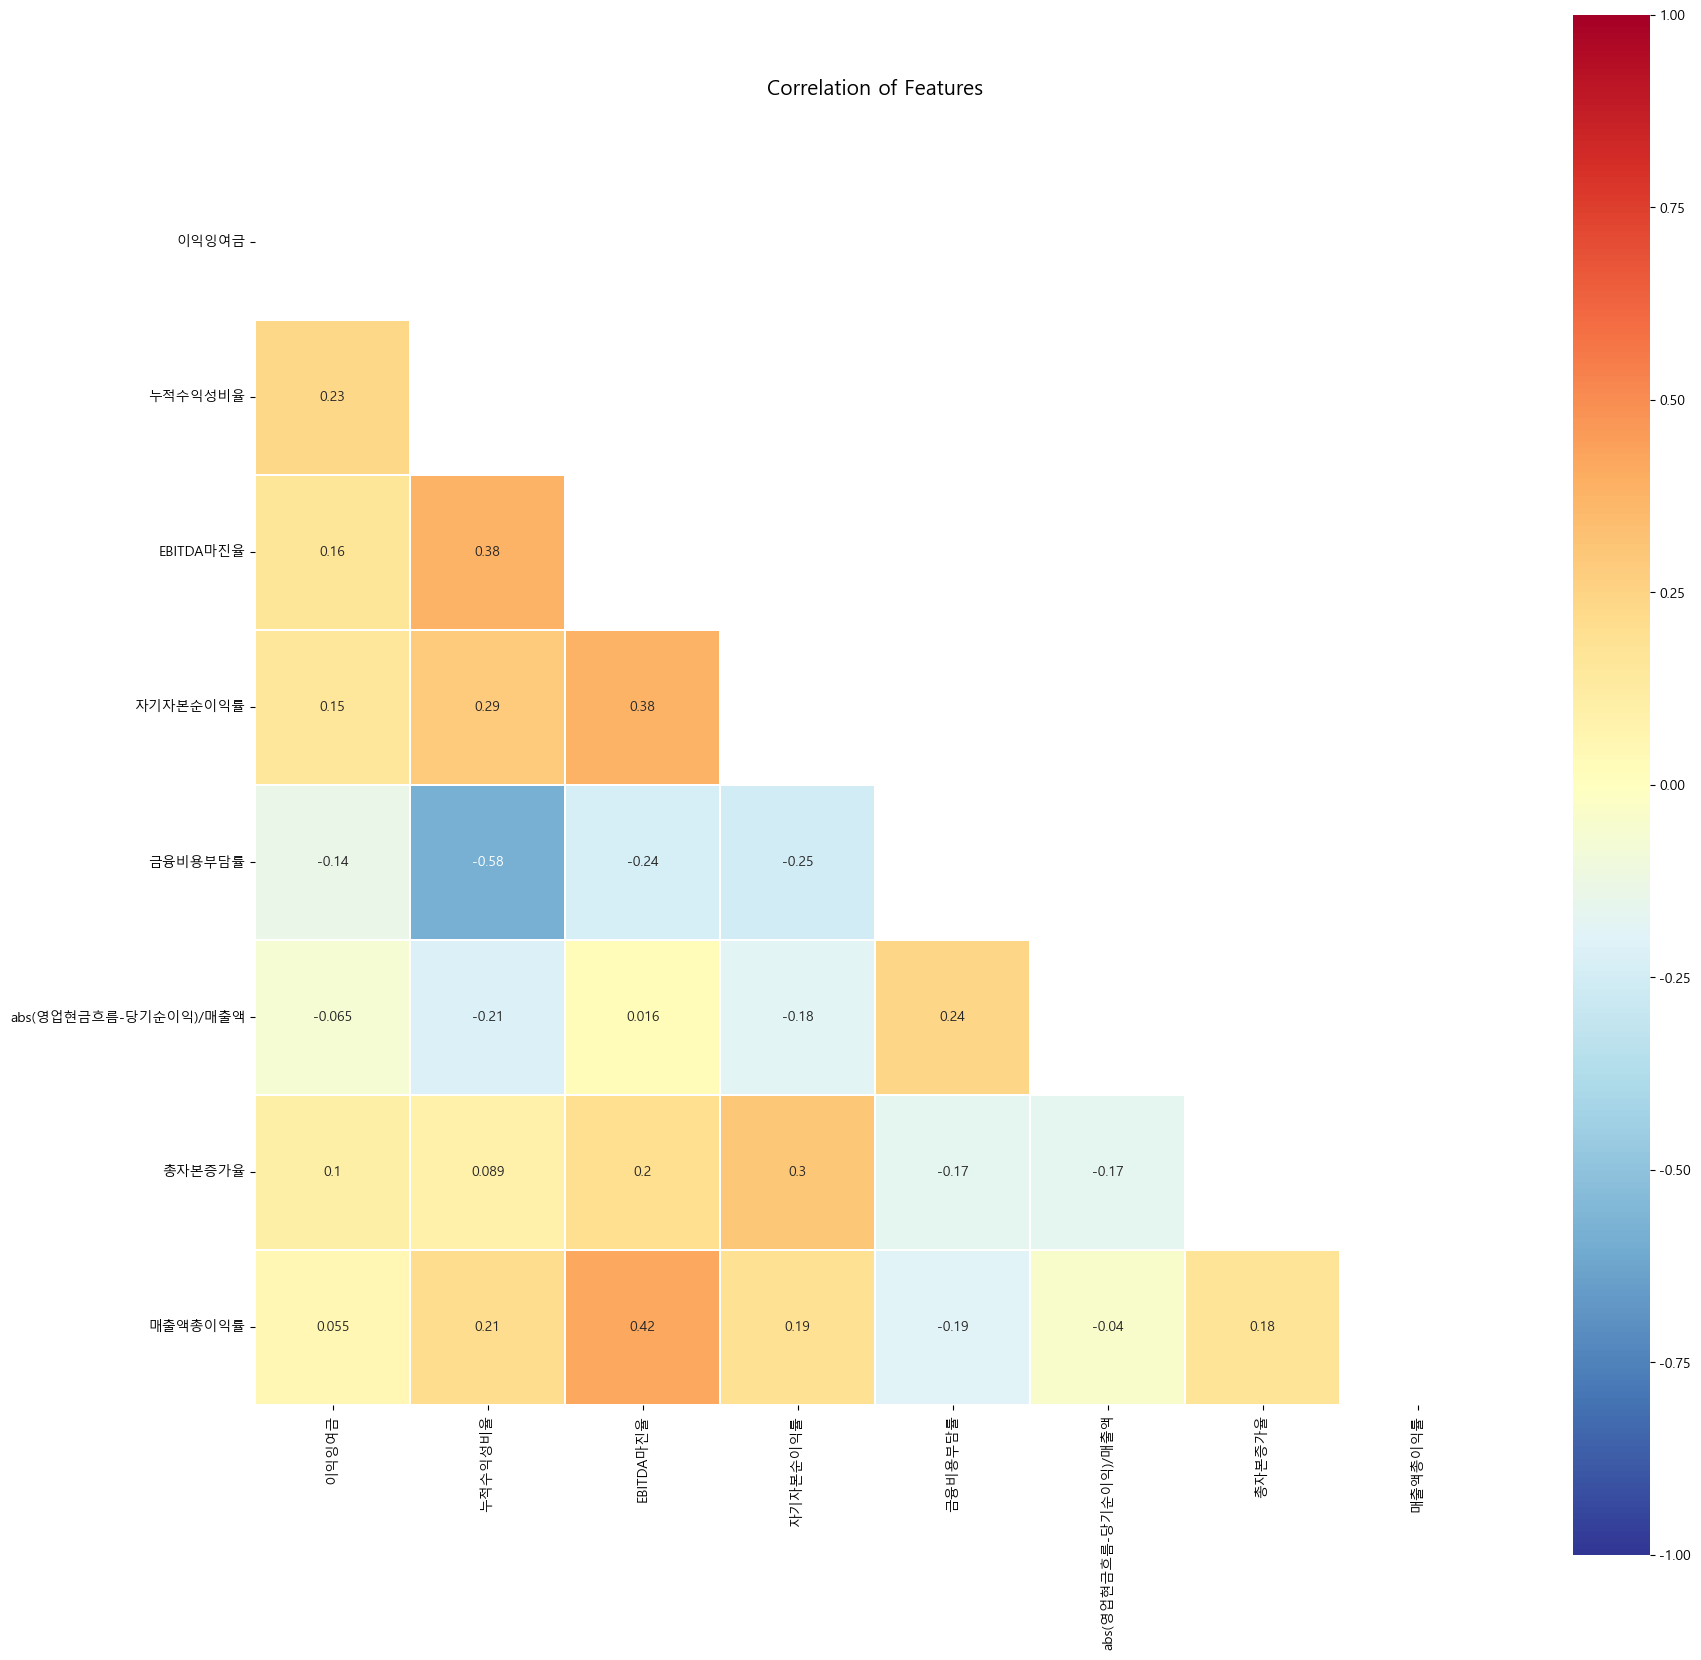

In [49]:
colormap = plt.cm.hot

corr = x_train_1.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
plt.figure(figsize=(20, 20))
plt.rcParams['axes.unicode_minus'] = False
plt.rc('font', family="Malgun Gothic")
plt.title("Correlation of Features", y=1.05, size=15)
sns.heatmap(corr,  linewidths=0.1, vmax=1.0, vmin=-1.0, square=True,mask=mask,
            cmap='RdYlBu_r', linecolor="white", annot=True, annot_kws={'size': 10})

In [50]:
model_basic(x_train_1,y_train,x_train_1,y_train)

[[3666    3]
 [  18   32]]
[[3657   12]
 [  17   33]]
[[3567  102]
 [  10   40]]
[[3669    0]
 [   0   50]]
[[3669    0]
 [   0   50]]


,model,accuracy,precision,recall,f1_score,auc_score
0,LogisticRegression(),0.9944,0.9143,0.64,0.7529,0.9862
1,LinearDiscriminantAnalysis(),0.9922,0.7333,0.66,0.6947,0.9624
2,GaussianNB(),0.9699,0.2817,0.80,0.4167,0.9741
3,"(DecisionTreeClassifier(max_features='sqrt', r...",1.0000,1.0000,1.00,1.0000,1.0000
4,"XGBClassifier(base_score=None, booster=None, c...",1.0000,1.0000,1.00,1.0000,1.0000


In [51]:
model_basic(x_train_1,y_train,x_test_1,y_test)

[[1959   45]
 [   6    3]]
[[1956   48]
 [   5    4]]
[[1839  165]
 [   3    6]]
[[1968   36]
 [   6    3]]
[[1974   30]
 [   6    3]]


,model,accuracy,precision,recall,f1_score,auc_score
0,LogisticRegression(),0.9747,0.0625,0.3333,0.1053,0.9713
1,LinearDiscriminantAnalysis(),0.9737,0.0769,0.4444,0.1311,0.9661
2,GaussianNB(),0.9165,0.0351,0.6667,0.0667,0.9309
3,"(DecisionTreeClassifier(max_features='sqrt', r...",0.9791,0.0769,0.3333,0.1250,0.9538
4,"XGBClassifier(base_score=None, booster=None, c...",0.9821,0.0909,0.3333,0.1429,0.9707


-----
# target2

In [52]:
x_train = train[col_int]
y_train = train[['target_2']]

x_test = test[col_int]
y_test = test[['target_2']]

#  선정된 피쳐를 저장하기 위한 데이터프레임 생성 
df_select_2 = pd.DataFrame()
# 생성된 데이터프레임의 인덱스 지정
df_select_2.index = x_train.columns

In [53]:
#  lasso
selector = SelectFromModel(estimator=LogisticRegression(penalty='l1',solver='liblinear',C=0.01)).fit(x_train, y_train)
df_select_2["lasso_0.01"] = selector.get_support()

selector = SelectFromModel(estimator=LogisticRegression(penalty='l1',solver='liblinear',C=0.05)).fit(x_train, y_train)
df_select_2["lasso_0.05"] = selector.get_support()

selector = SelectFromModel(estimator=LogisticRegression(penalty='l1',solver='liblinear',C=0.1)).fit(x_train, y_train)
df_select_2["lasso_0.1"] = selector.get_support()

# logit foward
estimator = LogisticRegression(penalty='l1',solver='liblinear',C=0.05)
selector = SequentialFeatureSelector(estimator,direction='forward',cv=5,n_jobs=-1)
selector.fit(x_train, y_train)
df_select_2['logit_fwd'] = selector.get_support().tolist()
# logit backward
selector = SequentialFeatureSelector(estimator,direction='backward',cv=5,n_jobs=-1)
selector.fit(x_train, y_train)
df_select_2['logit_bwd'] = selector.get_support().tolist()


# lda foward
estimator = LinearDiscriminantAnalysis(solver='svd')
selector = SequentialFeatureSelector(estimator,direction='forward',cv=5,n_jobs=-1)
selector.fit(x_train, y_train)
df_select_2['lda_fwd'] = selector.get_support().tolist()
# lda backward
selector = SequentialFeatureSelector(estimator,direction='backward',cv=5,n_jobs=-1,)
selector.fit(x_train, y_train)
df_select_2['lda_bwd'] = selector.get_support().tolist()

# # RandomForest_foward
# estimator = RandomForestClassifier()
# selector = SequentialFeatureSelector(estimator,direction='forward',cv=2,n_jobs=-1)
# selector.fit(x_train, y_train)
# df_select_2['RFC_fwd'] = selector.get_support().tolist()
# # RandomForest _ backward
# selector = SequentialFeatureSelector(estimator,direction='backward',cv=2,n_jobs=-1)
# selector.fit(x_train, y_train)
# df_select_2['RFC_bwd'] = selector.get_support().tolist()

In [56]:
for col in df_select_2.columns.to_list():
    df_select_2[col] = df_select_2[col].apply(lambda x : 1 if x==True else 0)
df_select_2['total'] = df_select_2.sum(axis=1)
df_select_2[df_select_2['total']>=4].index

Index(['이익잉여금', '누적수익성비율', '금융비용부담률', '자기자본회전률', '매출액증가율', '자기자본증가율',
       '정상영업이익증가율'],
      dtype='object')

In [57]:
최종_col =df_select_2[df_select_2['total']>=4].index.to_list()

x_train_2 = x_train[최종_col]
x_test_2 = x_test[최종_col]

<AxesSubplot:title={'center':'Correlation of Features'}>

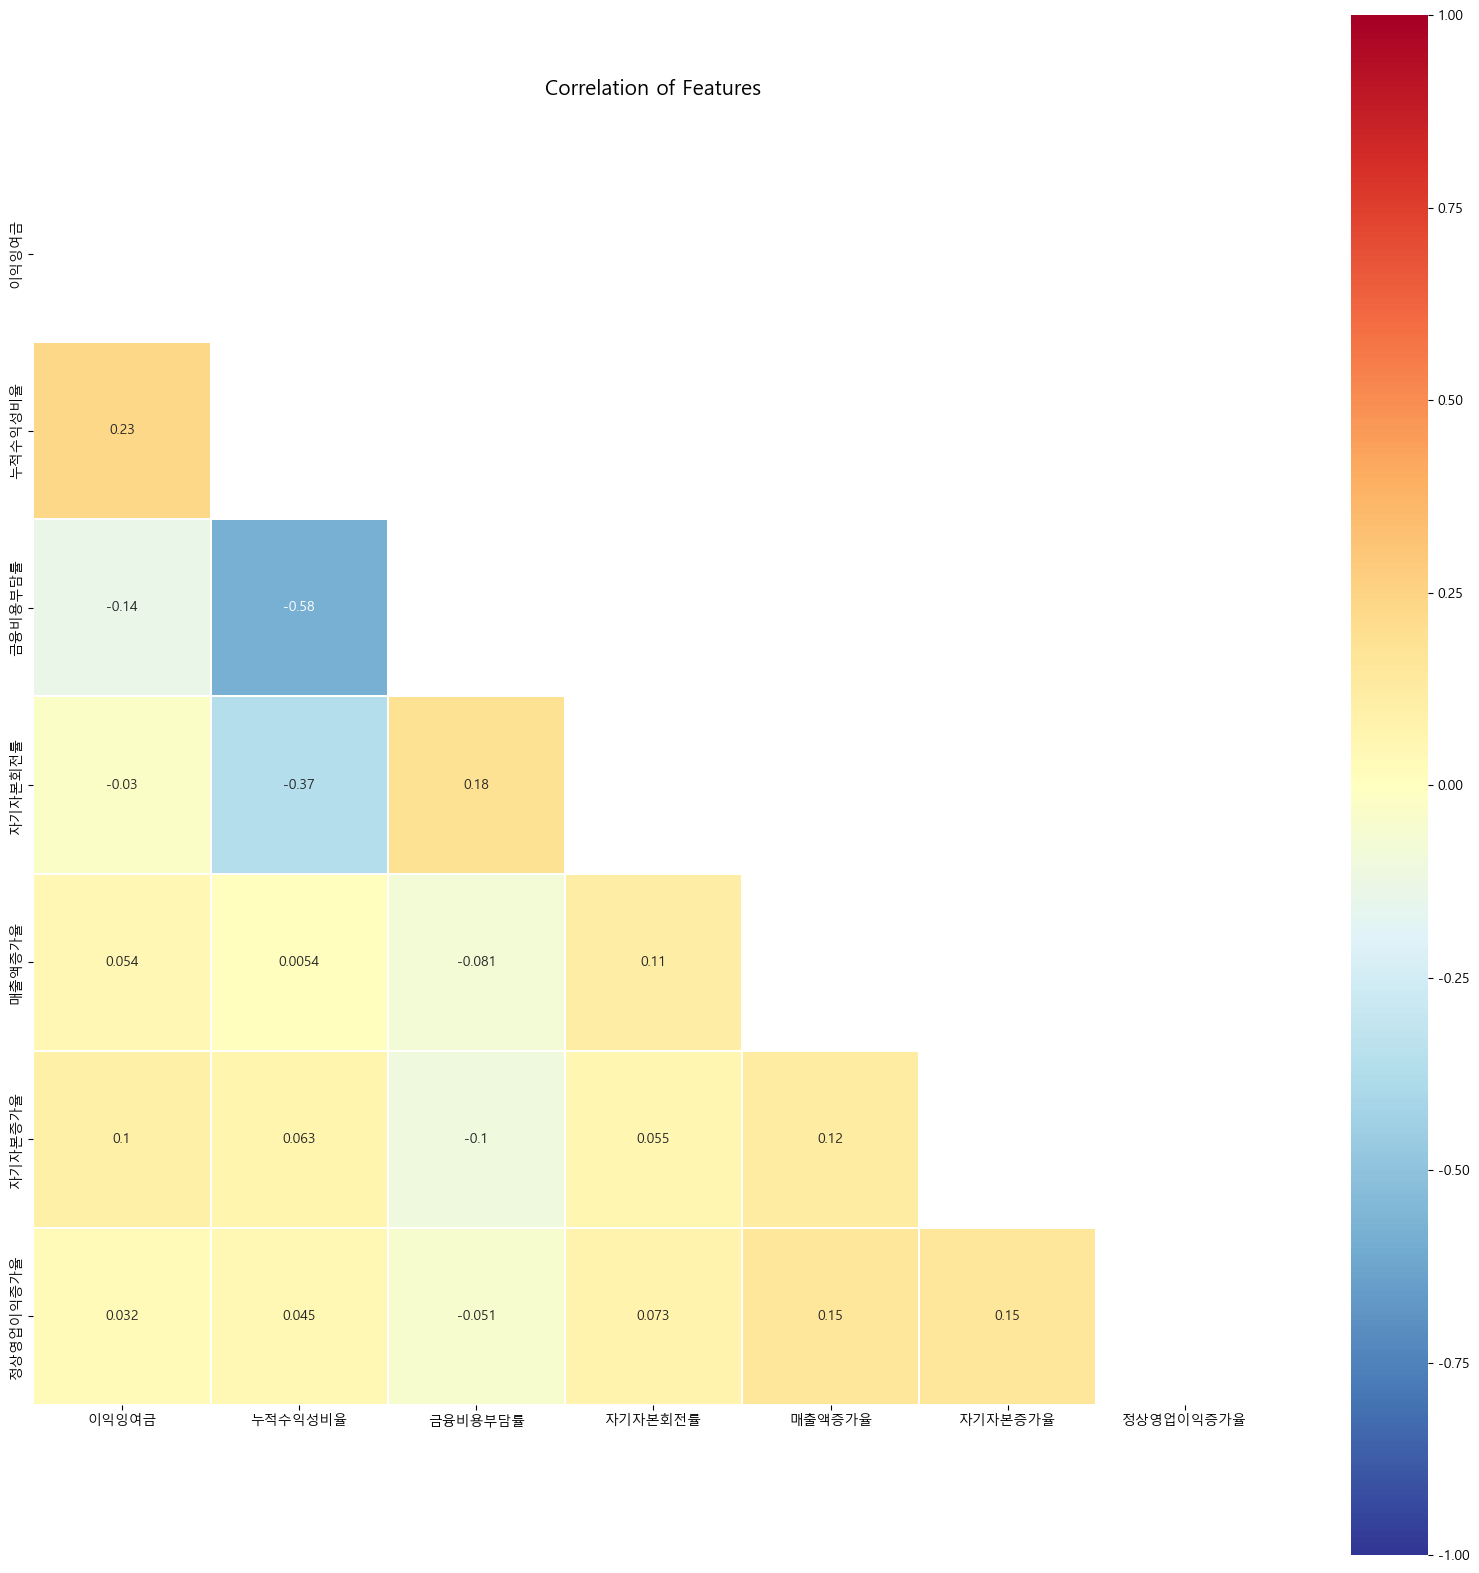

In [58]:
colormap = plt.cm.hot

corr = x_train_2.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
plt.figure(figsize=(20, 20))
plt.rcParams['axes.unicode_minus'] = False
plt.rc('font', family="Malgun Gothic")
plt.title("Correlation of Features", y=1.05, size=15)
sns.heatmap(corr,  linewidths=0.1, vmax=1.0, vmin=-1.0, square=True,mask=mask,
            cmap='RdYlBu_r', linecolor="white", annot=True, annot_kws={'size': 10})

In [59]:
model_basic(x_train_2,y_train,x_train_2,y_train)

[[3676    3]
 [  17   23]]
[[3670    9]
 [  18   22]]
[[3597   82]
 [  10   30]]
[[3679    0]
 [   0   40]]
[[3679    0]
 [   0   40]]


,model,accuracy,precision,recall,f1_score,auc_score
0,LogisticRegression(),0.9946,0.8846,0.575,0.6970,0.9877
1,LinearDiscriminantAnalysis(),0.9927,0.7097,0.550,0.6197,0.9136
2,GaussianNB(),0.9753,0.2679,0.750,0.3947,0.9782
3,"(DecisionTreeClassifier(max_features='sqrt', r...",1.0000,1.0000,1.000,1.0000,1.0000
4,"XGBClassifier(base_score=None, booster=None, c...",1.0000,1.0000,1.000,1.0000,1.0000


In [60]:
model_basic(x_train_2,y_train,x_test_2,y_test)

[[1969   33]
 [   8    3]]
[[1963   39]
 [   8    3]]
[[1849  153]
 [   8    3]]
[[1978   24]
 [   8    3]]
[[1985   17]
 [   9    2]]


,model,accuracy,precision,recall,f1_score,auc_score
0,LogisticRegression(),0.9796,0.0833,0.2727,0.1277,0.8347
1,LinearDiscriminantAnalysis(),0.9767,0.0714,0.2727,0.1132,0.8447
2,GaussianNB(),0.9200,0.0192,0.2727,0.0359,0.8294
3,"(DecisionTreeClassifier(max_features='sqrt', r...",0.9841,0.1111,0.2727,0.1579,0.7295
4,"XGBClassifier(base_score=None, booster=None, c...",0.9871,0.1053,0.1818,0.1333,0.8309


----
# target3

In [61]:
x_train = train[col_int]
y_train = train[['target_3']]

x_test = test[col_int]
y_test = test[['target_3']]

#  선정된 피쳐를 저장하기 위한 데이터프레임 생성 
df_select_3 = pd.DataFrame()
# 생성된 데이터프레임의 인덱스 지정
df_select_3.index = x_train.columns

In [63]:
#  lasso
selector = SelectFromModel(estimator=LogisticRegression(penalty='l1',solver='liblinear',C=0.01)).fit(x_train, y_train)
df_select_3["lasso_0.01"] = selector.get_support()

selector = SelectFromModel(estimator=LogisticRegression(penalty='l1',solver='liblinear',C=0.05)).fit(x_train, y_train)
df_select_3["lasso_0.05"] = selector.get_support()

selector = SelectFromModel(estimator=LogisticRegression(penalty='l1',solver='liblinear',C=0.1)).fit(x_train, y_train)
df_select_3["lasso_0.1"] = selector.get_support()

# logit foward
estimator = LogisticRegression(penalty='l1',solver='liblinear',C=0.05)
selector = SequentialFeatureSelector(estimator,direction='forward',cv=5,n_jobs=-1)
selector.fit(x_train, y_train)
df_select_3['logit_fwd'] = selector.get_support().tolist()
# logit backward
selector = SequentialFeatureSelector(estimator,direction='backward',cv=5,n_jobs=-1)
selector.fit(x_train, y_train)
df_select_3['logit_bwd'] = selector.get_support().tolist()


# lda foward
estimator = LinearDiscriminantAnalysis(solver='svd')
selector = SequentialFeatureSelector(estimator,direction='forward',cv=5,n_jobs=-1)
selector.fit(x_train, y_train)
df_select_3['lda_fwd'] = selector.get_support().tolist()
# lda backward
selector = SequentialFeatureSelector(estimator,direction='backward',cv=5,n_jobs=-1,)
selector.fit(x_train, y_train)
df_select_3['lda_bwd'] = selector.get_support().tolist()

# # RandomForest_foward
# estimator = RandomForestClassifier()
# selector = SequentialFeatureSelector(estimator,direction='forward',cv=2,n_jobs=-1)
# selector.fit(x_train, y_train)
# df_select_3['RFC_fwd'] = selector.get_support().tolist()
# # RandomForest _ backward
# selector = SequentialFeatureSelector(estimator,direction='backward',cv=2,n_jobs=-1)
# selector.fit(x_train, y_train)
# df_select_3['RFC_bwd'] = selector.get_support().tolist()

In [66]:
for col in df_select_3.columns.to_list():
    df_select_3[col] = df_select_3[col].apply(lambda x : 1 if x==True else 0)
df_select_3['total'] = df_select_3.sum(axis=1)
df_select_3[df_select_3['total']>=4].index

Index(['이익잉여금', '누적수익성비율', '금융비용부담률', '자기자본회전률', '매출액증가율', '자기자본증가율',
       '정상영업이익증가율'],
      dtype='object')

In [67]:
최종_col =df_select_3[df_select_3['total']>=4].index.to_list()

x_train_3 = x_train[최종_col]
x_test_3 = x_test[최종_col]

<AxesSubplot:title={'center':'Correlation of Features'}>

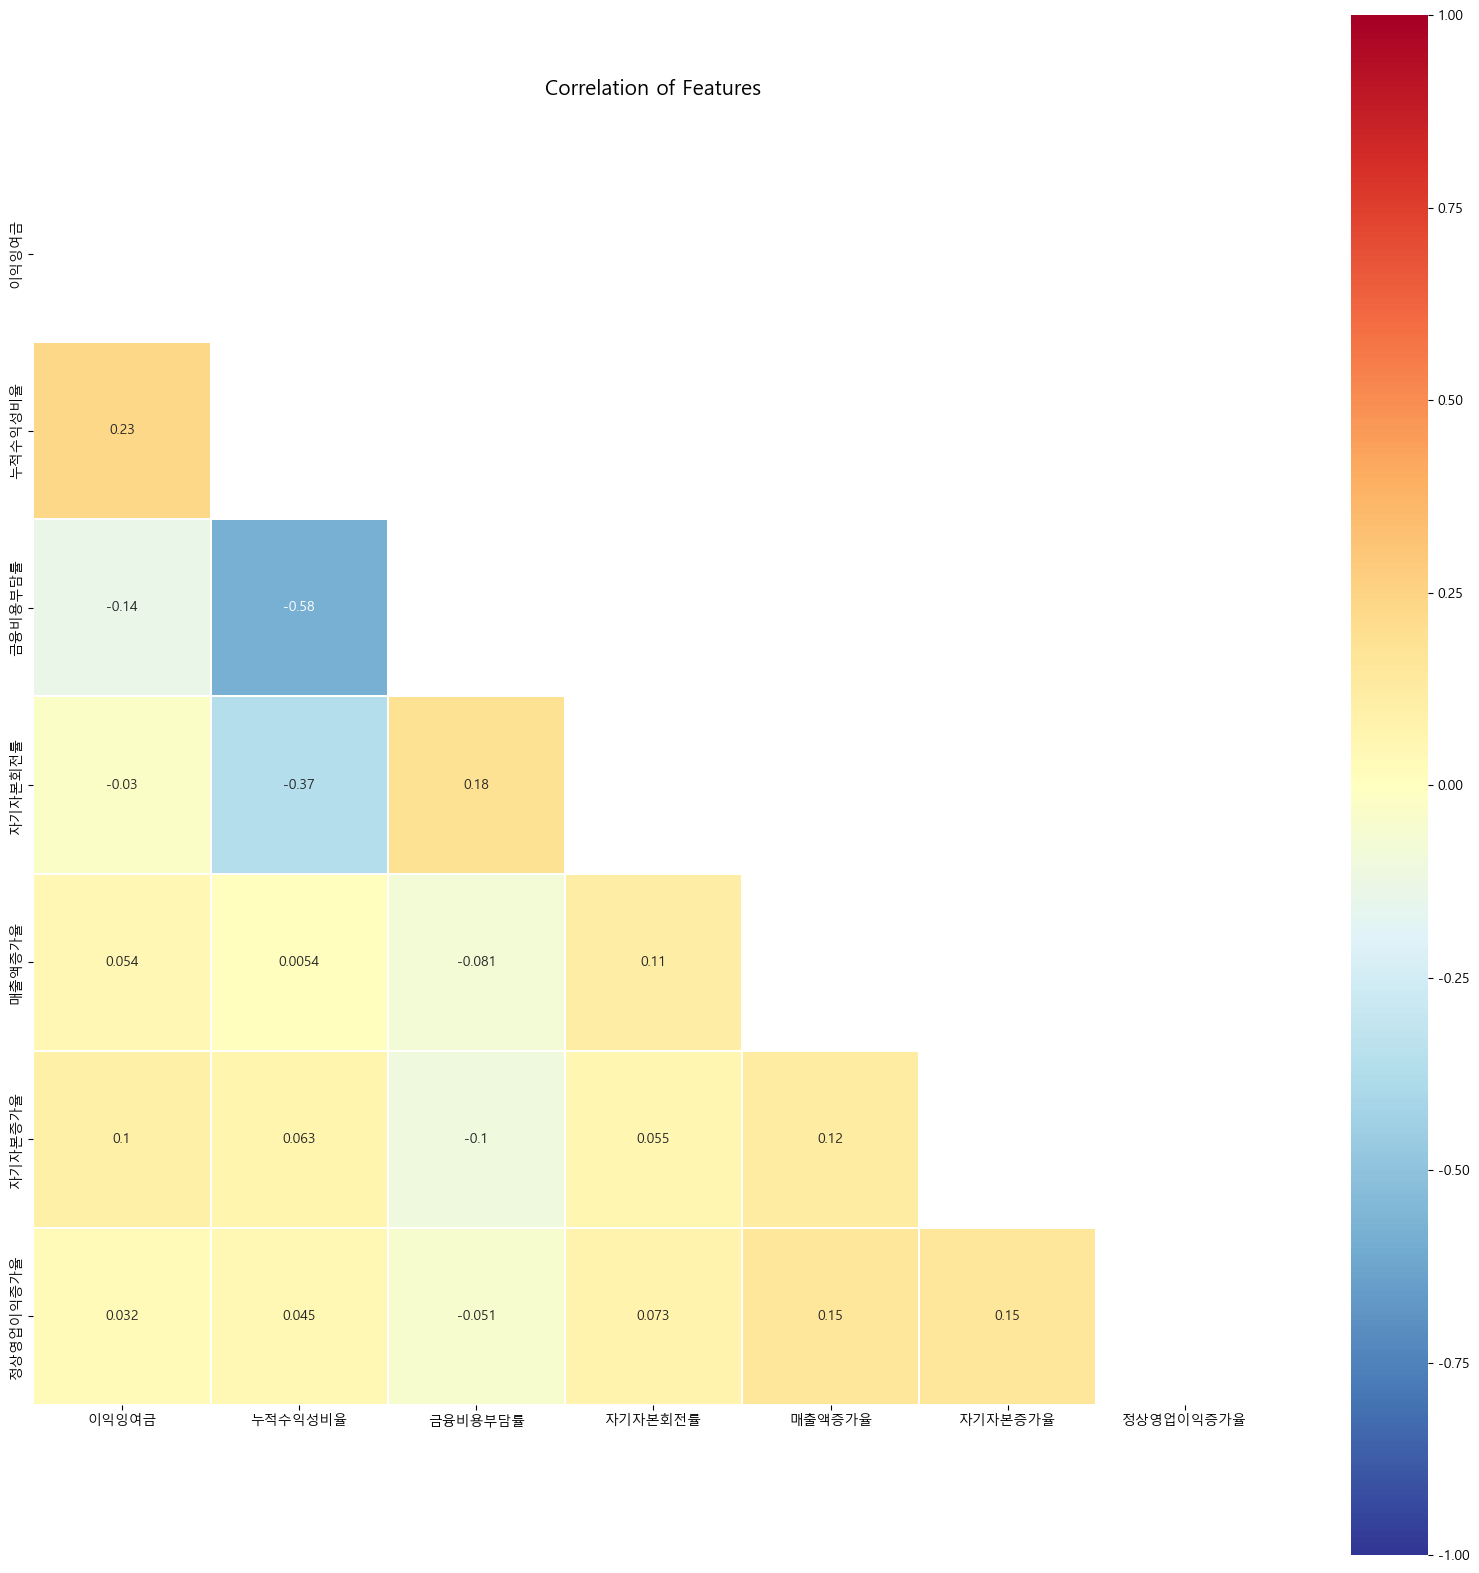

In [68]:
colormap = plt.cm.hot

corr = x_train_3.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
plt.figure(figsize=(20, 20))
plt.rcParams['axes.unicode_minus'] = False
plt.rc('font', family="Malgun Gothic")
plt.title("Correlation of Features", y=1.05, size=15)
sns.heatmap(corr,  linewidths=0.1, vmax=1.0, vmin=-1.0, square=True,mask=mask,
            cmap='RdYlBu_r', linecolor="white", annot=True, annot_kws={'size': 10})

In [69]:
model_basic(x_train_3,y_train,x_train_3,y_train)

[[3676    3]
 [  17   23]]
[[3670    9]
 [  18   22]]
[[3597   82]
 [  10   30]]
[[3679    0]
 [   0   40]]
[[3679    0]
 [   0   40]]


,model,accuracy,precision,recall,f1_score,auc_score
0,LogisticRegression(),0.9946,0.8846,0.575,0.6970,0.9877
1,LinearDiscriminantAnalysis(),0.9927,0.7097,0.550,0.6197,0.9136
2,GaussianNB(),0.9753,0.2679,0.750,0.3947,0.9782
3,"(DecisionTreeClassifier(max_features='sqrt', r...",1.0000,1.0000,1.000,1.0000,1.0000
4,"XGBClassifier(base_score=None, booster=None, c...",1.0000,1.0000,1.000,1.0000,1.0000


In [70]:
model_basic(x_train_3,y_train,x_test_3,y_test)

[[1974   33]
 [   3    3]]
[[1968   39]
 [   3    3]]
[[1854  153]
 [   3    3]]
[[1981   26]
 [   3    3]]
[[1990   17]
 [   4    2]]


,model,accuracy,precision,recall,f1_score,auc_score
0,LogisticRegression(),0.9821,0.0833,0.5000,0.1429,0.9724
1,LinearDiscriminantAnalysis(),0.9791,0.0714,0.5000,0.1250,0.9669
2,GaussianNB(),0.9225,0.0192,0.5000,0.0370,0.9239
3,"(DecisionTreeClassifier(max_features='sqrt', r...",0.9856,0.1034,0.5000,0.1714,0.8822
4,"XGBClassifier(base_score=None, booster=None, c...",0.9896,0.1053,0.3333,0.1600,0.9532
